In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from attention import MultiHeadAttention, PositionalEncoding
from components import PositionWiseFFN, AddNorm
from encoder_decoder import Encoder, Decoder, EncoderDecoder
import pandas as pd
import numpy as np
from torch.utils import data
import matplotlib.pyplot as plt
import matplotlib.style as style
from IPython import display
style.use('seaborn')
torch.manual_seed(42)

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [3]:

class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False):
        super(EncoderBlock, self).__init__()
        self.attention = MultiHeadAttention(key_size, query_size, value_size,
                                            num_hiddens, num_heads, dropout, use_bias)
        self.addNorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addNorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addNorm1(X, self.attention(X, X, X, valid_lens))
        return self.addNorm2(Y, self.ffn(Y))


class TransformerEncoder(Encoder):
    def __init__(self,
                 num_data_dim,
                 num_weather,
                 weather_embedder_dim,
                 num_hiddens,
                 norm_shape,
                 ffn_num_input,
                 ffn_num_hiddens,
                 num_heads,
                 num_layers,
                 dropout,
                 use_bias=False,
                 use_weather=True):
        super(TransformerEncoder, self).__init__()
        self.use_weather = use_weather
        self.num_hiddens = num_hiddens
        if use_weather:
            self._total_input_dim = num_data_dim + weather_embedder_dim
            self.weather_embedder = nn.Embedding(num_weather, weather_embedder_dim)
        else:
            self._total_input_dim = num_data_dim
        self.embedding = nn.Linear(self._total_input_dim, num_hiddens)
        self.pos_encoding = PositionalEncoding(self.num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("encoder_blk_%d" % i, EncoderBlock(num_hiddens,
                                                                    num_hiddens,
                                                                    num_hiddens,
                                                                    num_hiddens,
                                                                    norm_shape,
                                                                    ffn_num_input,
                                                                    ffn_num_hiddens,
                                                                    num_heads,
                                                                    dropout,
                                                                    use_bias))

    def forward(self, X, valid_lens, *args):
        if self.use_weather:
            data, weather = X
            weather = self.weather_embedder(weather)
            X = torch.cat((data, weather), dim=-1)
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X



In [4]:
encoder = TransformerEncoder(10, 5, 10, 24, [24], 24, 48, 8, 2, 0.5)
input_data = torch.randn(3, 10, 10)
input_weather = torch.randint(0, 5, (3, 10))
val_lens = torch.tensor([10, 10, 10])
X = (input_data, input_weather)
enc_outputs = encoder(X, val_lens)

In [5]:
enc_outputs.shape

torch.Size([3, 10, 24])

In [6]:
class DecoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i):
        super(DecoderBlock, self).__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addNorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addNorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addNorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]

        batch_size, num_steps, _ = X.shape
        dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        X2 = self.attention1(X, X, X, dec_valid_lens)
        Y = self.addNorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addNorm2(Y, Y2)
        return self.addNorm3(Z, self.ffn(Z)), state


class TransformerDecoder(Decoder):
    def __init__(self, num_data_dim, num_weather, weather_embedder_dim,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout,use_weather=True):
        super(TransformerDecoder, self).__init__()
        self._attention_weights = None
        self.seqX = None
        self.num_hiddens = num_hiddens
        self.use_weather = use_weather
        self.num_layers = num_layers
        if use_weather:
            self._total_input_dim = num_data_dim + weather_embedder_dim
            self.weather_embedder = nn.Embedding(num_weather, weather_embedder_dim)
        else:
            self._total_input_dim = num_data_dim
        self.pos_encoding = PositionalEncoding(self.num_hiddens, dropout)
        self.embedding = nn.Linear(self._total_input_dim, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 DecoderBlock(num_hiddens,
                                              num_hiddens,
                                              num_hiddens,
                                              num_hiddens,
                                              norm_shape,
                                              ffn_num_input,
                                              ffn_num_hiddens,
                                              num_heads,
                                              dropout,
                                              i))
        self.dense = nn.Linear(num_hiddens, num_data_dim+num_weather)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        self.seqX = None
        return [enc_outputs, enc_valid_lens]

    def forward(self, X, state):
        if self.use_weather:
            data, weather = X
            weather = self.weather_embedder(weather)
            X = torch.cat((data, weather), dim=-1)
        if not self.training:
            self.seqX = X if self.seqX is None else torch.cat((self.seqX, X), dim=1)
            X = self.seqX

        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        if not self.training:
            return self.dense(X)[:, -1:, :], state
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [7]:
decoder = TransformerDecoder(10, 5, 10, 24, [24], 24, 48, 8, 2, 0.5)
target_data = torch.randn(3, 5, 10)
target_weather = torch.randint(0, 5, (3, 5))
target_val_lens = torch.tensor([5, 5, 5])
target_X = (target_data, target_weather)
state = decoder.init_state(enc_outputs, val_lens)
dec_outputs, state = decoder(target_X, state)

In [8]:
dec_outputs.shape

torch.Size([3, 5, 15])

In [9]:
state[0].shape

torch.Size([3, 10, 24])

In [10]:
data_loss = nn.MSELoss()
weather_loss = nn.CrossEntropyLoss()
def combined_loss(pred, target_data, target_weather):
    data = pred[:, :, :target_data.shape[-1]]
    weather = pred[:, :, target_data.shape[-1]:]
    data_loss = nn.MSELoss()(data, target_data)
    weather_loss = nn.CrossEntropyLoss()(weather.permute(0, 2, 1), target_weather)
    return data_loss + weather_loss

In [11]:
combined_loss(dec_outputs, target_data, target_weather)

tensor(3.0161, grad_fn=<AddBackward0>)

In [12]:
import torch
import copy
from util import Accumulator, grad_clipping
torch.manual_seed(42)


def train_weather_transformer(model, num_epochs, train_data_iter, val_data_iter, loss, device, lr, mile_stone, gamma, pred_step_len):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=mile_stone, gamma=gamma)
    best_loss = float('inf')
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        metric = Accumulator(2)
        val_metric = Accumulator(2)
        display.clear_output(wait=True)
        model.train()
        for batch in train_data_iter:
            optimizer.zero_grad()
            X_data, X_weather, X_valid_len, Y_data, Y_weather, Y_valid_len = [x.to(device) for x in batch]
            bos_data = X_data[:, -1, :]
            bos_weather = X_weather[:, -1]
            dec_input_data = torch.cat([bos_data.unsqueeze(1), Y_data[:, :-1, :]], 1)
            dec_input_weather = torch.cat([bos_weather.unsqueeze(1), Y_weather[:, :-1]], 1)
            dec_input = (dec_input_data, dec_input_weather)
            X = (X_data, X_weather)
            Y_hat, _ = model(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y_data, Y_weather)
        #     X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
        #     bos = torch.tensor([target_vocab['<bos>']] * Y.shape[0], device=device).reshape(-1, 1)
        #     dec_input = torch.cat([bos, Y[:, :-1]], 1)
        #     Y_hat, _ = model(X, dec_input, X_valid_len)
        #     print(Y_hat.shape)
        #     l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            grad_clipping(model, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        model.eval()
        for batch in val_data_iter:

            X_data, X_weather, X_valid_len, Y_data, Y_weather, Y_valid_len = [x.to(device) for x in batch]
            X_data = X_data.to(device)
            X_weather = X_weather.to(device)
            X_valid_len = X_valid_len.to(device)
            X = (X_data, X_weather)
            enc_outputs = model.encoder(X, X_valid_len)
            dec_state = model.decoder.init_state(enc_outputs, X_valid_len)
            bos_data = X_data[:, -1, :].unsqueeze(1)
            bos_weather = X_weather[:, -1].unsqueeze(1)
            dec_input = (bos_data, bos_weather)
            output_weathers = torch.zeros((X_data.shape[0], pred_step_len, num_data_dim+num_weather), device=device)
            for i in range(pred_step_len):
                Y_hat, dec_state = model.decoder(dec_input, dec_state)
                output_weathers[:, i, :] = Y_hat.squeeze(1)
                dec_input = (Y_hat[:, :, :num_data_dim], Y_hat[:, :, num_data_dim:].argmax(dim=2))
            l = loss(output_weathers, Y_data, Y_weather)
            num_tokens = Y_valid_len.sum()
            val_metric.add(l.sum(), num_tokens)
        train_loss.append((metric[0] / metric[1]))
        val_loss.append((val_metric[0] / val_metric[1]))
        print('Epoch: {}/{}.............'.format(epoch+1, num_epochs), end=' ')
        print("Train Loss: {:.4f}, Validation Loss: {:.4f}".format((metric[0] / metric[1]), (val_metric[0] / val_metric[1])))

        if (metric[0] / metric[1]) < best_loss:
            best_loss = (metric[0] / metric[1])
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(best_weights, 'test_weather_predicting.pth')
        plt.plot(train_loss)
        plt.plot(val_loss)
        plt.tight_layout()
        plt.show()
        scheduler.step()

In [13]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def create_weather_dataset(file, input_len, output_len, batch_size=64):
    all_data_and_weather = pd.read_csv(file).to_numpy()
    used_data_and_weather = all_data_and_weather[:(len(all_data_and_weather)//(input_len+output_len)) * (input_len+output_len)]
    data = used_data_and_weather[:, :-1]
    weather = used_data_and_weather[:, -1]
    data_split = np.split(data, len(data)//(input_len+output_len))
    weather_split = np.split(weather, len(weather)//(input_len+output_len))
    X_data = torch.tensor(np.stack([i[:input_len] for i in data_split]), dtype=torch.float)
    X_weather = torch.tensor(np.stack([i[:input_len] for i in weather_split]), dtype=torch.long)
    Y_data = torch.tensor(np.stack([i[input_len:] for i in data_split]), dtype=torch.float)
    Y_weather = torch.tensor(np.stack([i[input_len:] for i in weather_split]), dtype=torch.long)
    X_valid_len = torch.tensor([input_len] * len(X_data), dtype=torch.long)
    Y_valid_len = torch.tensor([output_len] * len(Y_data), dtype=torch.long)
    return load_array((X_data, X_weather, X_valid_len, Y_data, Y_weather, Y_valid_len), batch_size)


In [14]:
train_batch_size = 64
val_batch_size = 256
test_batch_size = 256
train_iter = create_weather_dataset('train_data1.csv', 72, 24, train_batch_size)
val_iter = create_weather_dataset('valid_data1.csv', 72, 24, val_batch_size)
test_iter = create_weather_dataset('test_data1.csv', 72, 24, test_batch_size)

In [15]:
num_hiddens, num_layers, dropout= 64, 4, 0.2
input_num_steps, target_num_steps = 72, 24
lr, num_epochs = 0.0008, 1000
ffn_num_input, ffn_num_hiddens, num_heads = 64, 256, 8
num_data_dim, num_weather = 7, 27
weather_embedder_dim = 16
norm_shape = [num_hiddens]

In [16]:
encoder = TransformerEncoder(num_data_dim,
                             num_weather,
                             weather_embedder_dim,
                             num_hiddens,
                             norm_shape,
                             ffn_num_input,
                             ffn_num_hiddens,
                             num_heads,
                             num_layers,
                             dropout)

decoder = TransformerDecoder(num_data_dim,
                                num_weather,
                                weather_embedder_dim,
                                num_hiddens,
                                norm_shape,
                                ffn_num_input,
                                ffn_num_hiddens,
                                num_heads,
                                num_layers,
                                dropout)

model = EncoderDecoder(encoder, decoder)

In [17]:
model = model.to(device)

Epoch: 1000/1000............. Train Loss: 0.0052, Validation Loss: 0.0164


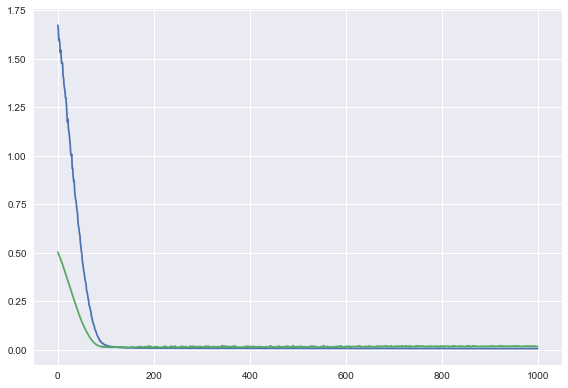

In [18]:
mile_stone = []
for i in range(1, 10):
    mile_stone.append((num_epochs * i)//20)
stepping_rate = 0.9

train_weather_transformer(model, num_epochs, train_iter, val_iter, combined_loss, device, lr, mile_stone, stepping_rate, target_num_steps)

In [40]:
model.load_state_dict(torch.load('weather_predicting.pth'))

<All keys matched successfully>

In [42]:
def predict_weather(model, X_data, X_weather, X_valid_len, pred_step_len):
    model.eval()
    if len(X_data.shape) < 3:
        X_data = X_data.unsqueeze(0)
        X_weather = X_weather.unsqueeze(0)
        X_valid_len = X_valid_len.unsqueeze(0)

    X_data = X_data.to(device)
    X_weather = X_weather.to(device)
    X_valid_len = X_valid_len.to(device)
    X = (X_data, X_weather)
    enc_outputs = model.encoder(X, X_valid_len)
    dec_state = model.decoder.init_state(enc_outputs, X_valid_len)
    bos_data = X_data[:, -1, :].unsqueeze(1)
    bos_weather = X_weather[:, -1].unsqueeze(1)
    dec_input = (bos_data, bos_weather)
    output_seq = []
    for _ in range(pred_step_len):
        Y, dec_state = model.decoder(dec_input, dec_state)
        Y_data = Y[:, :, :num_data_dim]
        Y_weather = Y[:, :, num_data_dim:].argmax(dim=2)
        dec_input = (Y_data, Y_weather)
        output_seq.append(dec_input)
    return output_seq


In [43]:
test_X_data, test_X_weather, test_X_valid_len, test_Y_data, test_Y_weather, test_Y_valid_len = [x.to(device) for x in next(iter(test_iter))]
output_seq = predict_weather(model, test_X_data[0], test_X_weather[0], test_X_valid_len[0], 24)


In [44]:
output_seq[0][0]

tensor([[[ 10.6771,   0.2278,  48.5800,  -0.1099,  21.4133, 101.6609,  16.2008]]],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [42]:
def create_test_dataset(file, input_len, output_len, batch_size=64):
    all_data_and_weather = pd.read_csv(file).to_numpy()
    used_data_and_weather = all_data_and_weather[:(len(all_data_and_weather)//(input_len+output_len)) * (input_len+output_len)]
    data = used_data_and_weather[:, :-1]
    weather = used_data_and_weather[:, -1]
    data_split = []
    weather_split = []
    for i in range(0, len(data)-(input_len+output_len)+1, output_len):
        data_split.append(data[i:i+input_len+output_len])
        weather_split.append(weather[i:i+input_len+output_len])

    X_data = torch.tensor(np.stack([i[:input_len] for i in data_split]), dtype=torch.float)
    X_weather = torch.tensor(np.stack([i[:input_len] for i in weather_split]), dtype=torch.long)
    Y_data = torch.tensor(np.stack([i[input_len:] for i in data_split]), dtype=torch.float)
    Y_weather = torch.tensor(np.stack([i[input_len:] for i in weather_split]), dtype=torch.long)
    X_valid_len = torch.tensor([input_len] * len(X_data), dtype=torch.long)
    Y_valid_len = torch.tensor([output_len] * len(Y_data), dtype=torch.long)
    return load_array((X_data, X_weather, X_valid_len, Y_data, Y_weather, Y_valid_len), batch_size)

In [43]:
test_iter = create_test_dataset('test_data1.csv', 72, 24, test_batch_size)

In [61]:
def test_model_performance(model, data_iter, pred_step_len):
    model.eval()
    metric = Accumulator(2)
    ground_truth = []
    predicted_data = []
    ground_truth_weather = []
    predicted_weather = []
    for batch in data_iter:
        X_data, X_weather, X_valid_len, Y_data, Y_weather, Y_valid_len = [x.to(device) for x in batch]
        X_data = X_data.to(device)
        X_weather = X_weather.to(device)
        X_valid_len = X_valid_len.to(device)
        X = (X_data, X_weather)
        enc_outputs = model.encoder(X, X_valid_len)
        dec_state = model.decoder.init_state(enc_outputs, X_valid_len)
        bos_data = X_data[:, -1, :].unsqueeze(1)
        bos_weather = X_weather[:, -1].unsqueeze(1)
        dec_input = (bos_data, bos_weather)
        output_weathers = torch.zeros((X_data.shape[0], pred_step_len, num_data_dim+num_weather), device=device)
        for i in range(pred_step_len):
            Y_hat, dec_state = model.decoder(dec_input, dec_state)
            output_weathers[:, i, :] = Y_hat.squeeze(1)
            dec_input = (Y_hat[:, :, :num_data_dim], Y_hat[:, :, num_data_dim:].argmax(dim=2))
            predicted_weather.extend(Y_hat[:, :, num_data_dim:].argmax(dim=2).reshape(-1).tolist())
        l = combined_loss(output_weathers, Y_data,Y_weather)
        # change column number to change which data to visualize (0 for temperature, 1 for dew point, etc.)
        ground_truth.extend(Y_data.reshape(-1, Y_data.shape[-1])[:, 0].tolist())
        ground_truth_weather.extend(Y_weather.reshape(-1).tolist())
        predicted_data.extend(output_weathers.reshape(-1, output_weathers.shape[-1])[:, 0].tolist())
        num_tokens = Y_valid_len.sum()
        metric.add(l.sum(), num_tokens)

    print("Loss: {:.4f}".format((metric[0] / metric[1])))
    plt.figure(figsize=(55, 10))
    plt.plot(ground_truth)
    plt.plot(predicted_data)
    plt.tight_layout()
    plt.show()
    weather_accuracy = torch.tensor(predicted_weather) == torch.tensor(ground_truth_weather)
    print("Weather accuracy: {:.4f}".format(weather_accuracy.sum().item()/len(weather_accuracy)))





Loss: 0.0188


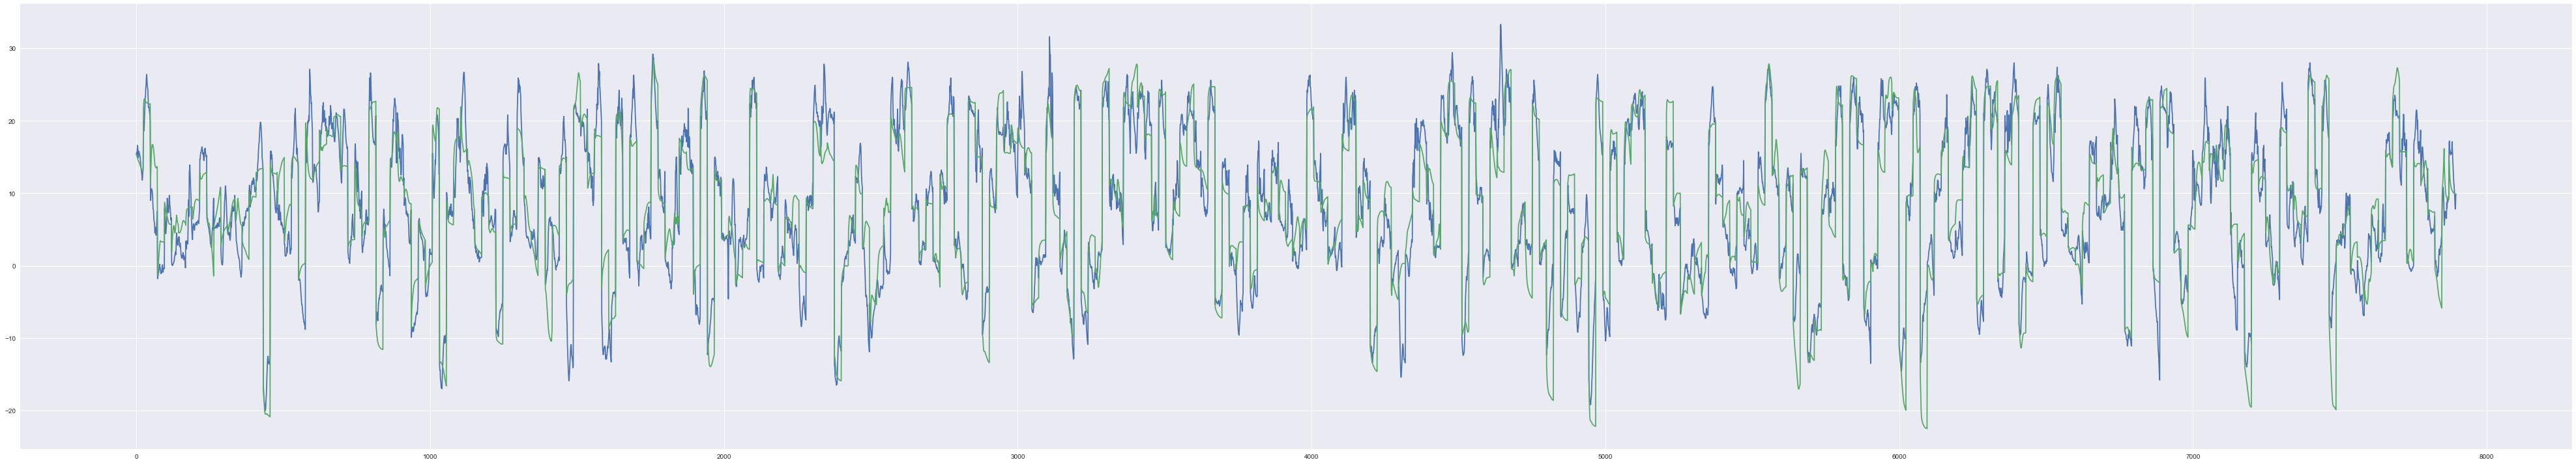

Weather accuracy: 0.7443


In [62]:
test_model_performance(model, test_iter, 24)